# 4DVar for Advection and Diffusion of an Inert Tracer

This notebook shows a demonstration of the single-window hard- and weak-constraint 4D-Var methods.
We consider the advection and diffusion of an inert tracer in a 1d system.
Specifically, we model a horizontally homogeneous water system with tides, e.g. an estuary.
We consider a tracer that is suspended in the fluid and is inert in the sense that it does not interact with other tracers.
It only has a constant sinking velocity and follows the motion of the water otherwise.
It thus obeys the transport equation

$\frac{\partial Y}{\partial t} = \underbrace{-w_{sinking} \frac{\partial Y}{\partial z}}_{\text{advection (sinking)}} + \underbrace{\frac{\partial}{\partial z}\left(\nu\frac{\partial Y}{\partial z}\right)}_{\text{diffusion (turbulence)}}$

with the tracer concentration $Y(t, z)$, the constant sinking velocity $w_{sinking}$ and the turbulent diffusivity $\nu(t, z)$.

For the numerical solving of this equation, we use the operators provided by the *tridiag* repository.
They follow the numerical schemes of [GOTM](https://gotm.net/) (General Ocean Turbulence Model) by Umlauf, Burchard, Bolding et al.

## Setup of the tracer simulation

At first, we import some packages we need for this notebook:

In [ ]:
# import standard packages
import matplotlib.pyplot as plt
import numpy as np
import torch
from tensordict import TensorDict
from time import time
import os

# import from the diffops/tridiag package
from diffops.fabm.passive_model import PassiveModel
from diffops.gotm.gotm import TracerSimulationOperator

# import from the da_tools package
os.chdir('..')
from da_tools.variational.hard_constraint_4dvar import hc4dvar_single_window
from da_tools.variational.weak_constraint_4dvar import wc4dvar_single_window
from da_tools.system.state import State
from da_tools.observation.operators import random_sparse_noisy_obs
from da_tools.util.initialization import naive_initialization
from da_tools.probability.distributions import DiagonalGaussian

Now, we load the turbulent diffusivity field that was pre-computed with GOTM (General Ocean Turbulence Model):

In [ ]:
nu = torch.load('notebooks/GOTM/data_gotm_nu_1d_sinking.pt')

Finally, we set up all other required fields and inputs in closed form:

In [ ]:
t = torch.linspace(0., 86400., 2161, dtype=torch.float64)  # time [seconds]

# the tidal forcing for the sea surface elevation:
period_1 = 44714.0                     # period of 1st harmonic (eg. M2-tide) [s]
amp_1 = 0.2                            # amplitude of 1st harmonic [m]
phase_1 = 11178.5                      # phase of 1st harmonic [s]
period_2 = 43200.0                     # period of 2nd harmonic (eg. S2-tide) [s]
amp_2 = 0.04                           # amplitude of 2nd harmonic [m]
phase_2 = 10800.0                      # phase of 2nd harmonic [s]

# the sea surface elevation:
zeta = amp_1 * torch.sin(2*torch.pi*(t - phase_1)/period_1) + amp_2 * torch.sin(2*torch.pi*(t - phase_2)/period_2)

# parameters for the parameterization of our coordinates (sigma-coordinates):
ddl = torch.tensor(1.0, dtype=torch.float64)
ddu = torch.tensor(1.0, dtype=torch.float64)
N = nu.shape[1]-1
sigma_k = torch.arange(0, N+1, dtype=torch.float64)/N - 1
beta_k = (torch.tanh((ddl+ddu)*(1+sigma_k)-ddl)+torch.tanh(ddl)) / (torch.tanh(ddl) + torch.tanh(ddu)) - 1

# the grid coordinates and layer heights:
zi = zeta[:, None] + beta_k * (15 + zeta[:, None])
z = ((zi[:, 1:] + zi[:, :-1])/2)
h = torch.diff(zi, axis=1)

# the initial concentrations:
init_state_1 = torch.full((11,), 0.5, dtype=torch.float64)
def _interpolate(_i0, _i1, _val0, _val1):
    _i = z[0, _i0:_i1]
    _i = (_i - _i[0]) / (_i[-1] - _i[0])
    return _val0 + (_val1-_val0)*_i
init_state_1 = torch.cat((init_state_1, _interpolate(11, 25, 0.5104294010330814, 0.9686299287889018))) #torch.linspace(0.5104, 0.9686, 14)))
init_state_1 = torch.cat((init_state_1, _interpolate(25, 32, 0.9852598575778037, 0.5313494069237636))) #torch.linspace(0.9853, 0.5313, 7)))
init_state_1 = torch.cat((init_state_1, _interpolate(32, 40, 0.5807378033281125, 1.4773042119403872))) #torch.linspace(0.5807, 1.4773, 8)))
init_state_1 = torch.cat((init_state_1, torch.full((10,), 1.5, dtype=torch.float64)))

### Visualization of simulation inputs/forcings

First, we define a function that we can use for plotting time series' of the tracer.

In [ ]:
def show_tracer_ts(ts_, ax=None,
                   title="Tracer concentration from PyTorch simulation",
                   label_colorbar="tracer concentration [mol/m$^3$]",
                   cmap=None, vmin=None, vmax=None, center_on_zero=False, t_=t, z_=z):
    if ax is None:
        ax = plt.gca()
    if isinstance(ts_, TensorDict):
        ts_ = ts_['pelagic']
    if center_on_zero:
        vmax_abs = torch.max(torch.abs(ts_))
        vmin, vmax = -vmax_abs, vmax_abs
    pcol = ax.pcolormesh(t_, z_.T, ts_.squeeze().T, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(pcol, ax=ax, label=label_colorbar)
    for i in range(0, z_.shape[1], z_.shape[1]//10):
        ax.plot(t_, z_[:, i], ls='--', c='gray', label=f"layer {i}")
    ax.set_xlabel("$t$ [s]")
    ax.set_ylabel("$z$ [m]")
    ax.set_title(title)

Let us now have a look at the inputs to our simulation we just defined:

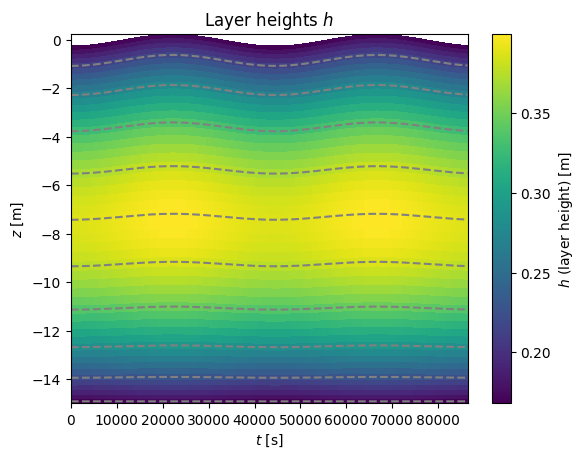

In [ ]:
show_tracer_ts(h, title='Layer heights $h$', label_colorbar='$h$ (layer height) [m]')
plt.show()

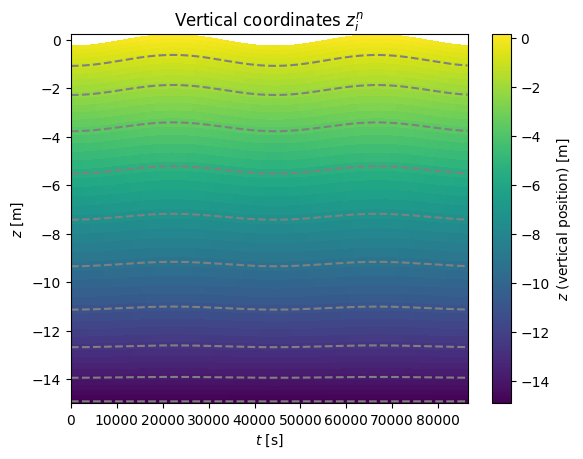

In [ ]:
show_tracer_ts(z, title='Vertical coordinates $z_i^n$', label_colorbar="$z$ (vertical position) [m]")
plt.show()

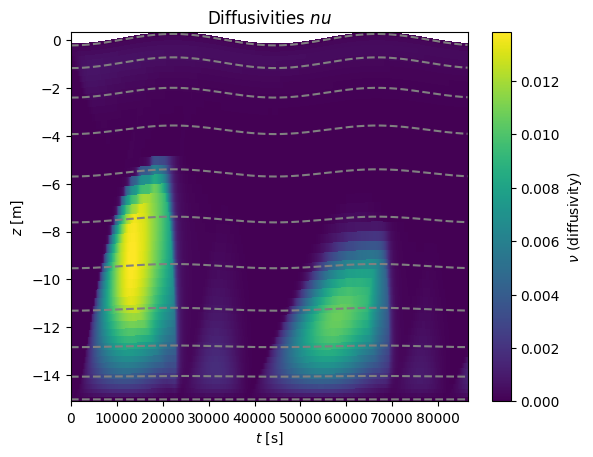

In [ ]:
show_tracer_ts(nu, title='Diffusivities $nu$', label_colorbar="$\\nu$ (diffusivity)", z_=zi)
plt.show()

## Setup 4DVar

Before we use hard- and weak-constraint 4DVar for data assimilation on our system, we need to make some preparations.
For this, we first define our initial condition as a *State* object from the da-tools package:

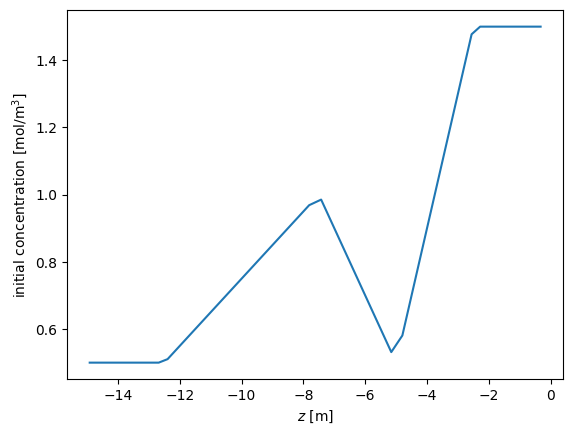

In [ ]:
initial_state = State(TensorDict({'pelagic': init_state_1[None, None, None, :]}, batch_size=(1, 1)))
true_initial_state = initial_state
plt.plot(z[0], initial_state.fields['pelagic'].squeeze())
plt.xlabel('$z$ [m]')
plt.ylabel('initial concentration [mol/m$^3$]')
plt.show()

Now, we set up our physical model. We define a tracer model with a constant sinking velocity, and a forward operator that applies advection and diffusion as a split-step method:

In [ ]:
model = PassiveModel(torch.tensor(-5./(60**2*24), dtype=torch.float64))
forward_operator = TracerSimulationOperator(
    bc_up_type_dif="neumann", bc_down_type_dif="neumann", bc_up_value_dif=0., bc_down_value_dif=0.,
    bc_up_type_adv="flux", bc_down_type_adv="flux", bc_up_value_adv=0., bc_down_value_adv=0.,
    scheme_adv="p2_pdm", conserve=False, implicitness=1., allow_negative=False, model=model)

Now, we perform the simulation once for generating our true concentrations:

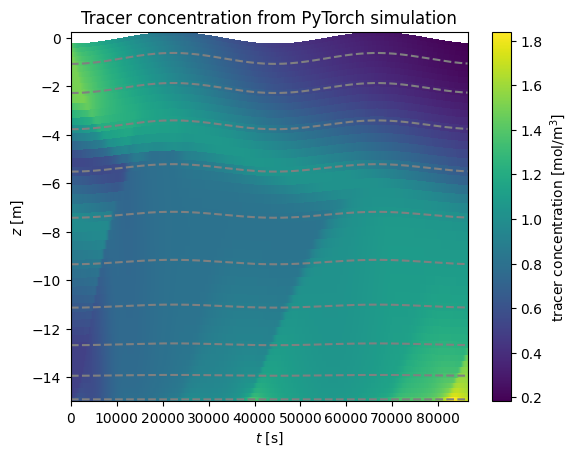

In [ ]:
ts_length = nu.shape[0]
time_step = torch.mean(torch.diff(t))
forecast_steps = t
h_input = h.unsqueeze(0).unsqueeze_(2)
nu_input = nu.unsqueeze(0).unsqueeze_(2)
ts = forward_operator.integrate(initial_state.fields[:, 0], time_step, h_input, nu_input)
ts = State(ts, time_axis=forecast_steps)

show_tracer_ts(ts.fields['pelagic'].squeeze())

In [ ]:
true_ts = ts[:]
forecast_steps = forecast_steps

true_ts = State(true_ts.fields, time_axis=forecast_steps)

We now add some Gaussian noise and a binary mask on the true time series, in order to generate corresponding observations.

In [ ]:
noise_amplitude = 0.2  # observation noise s.d.
p_obs = 0.1 # 90% of the variables are masked

torch.random.manual_seed(42)
groundtruth, obs_op, observations = random_sparse_noisy_obs(ts, noise_amplitude, p_obs)

# ensure concentrations are always non-negative
torch.clamp_min_(observations.state.fields['pelagic'], 0.)

valid_obs = observations.state.fields['pelagic'].squeeze()
valid_obs[torch.logical_not(observations.mask.fields['pelagic'].squeeze())] = torch.nan

Now, we build an initial guess for the initial state using the available observations.
We simply use the first available observation for each vertical position.
Clearly, this is not the optimal initial state because it contains time-shifted data and also noise.

As hard-constraint 4DVar only optimizes the initial state, we restrict the corresponding initialization.

In [ ]:
initialization = naive_initialization(observations)  # state estimate for all time points
initialization_hc = initialization[:, :1]  # first time point only

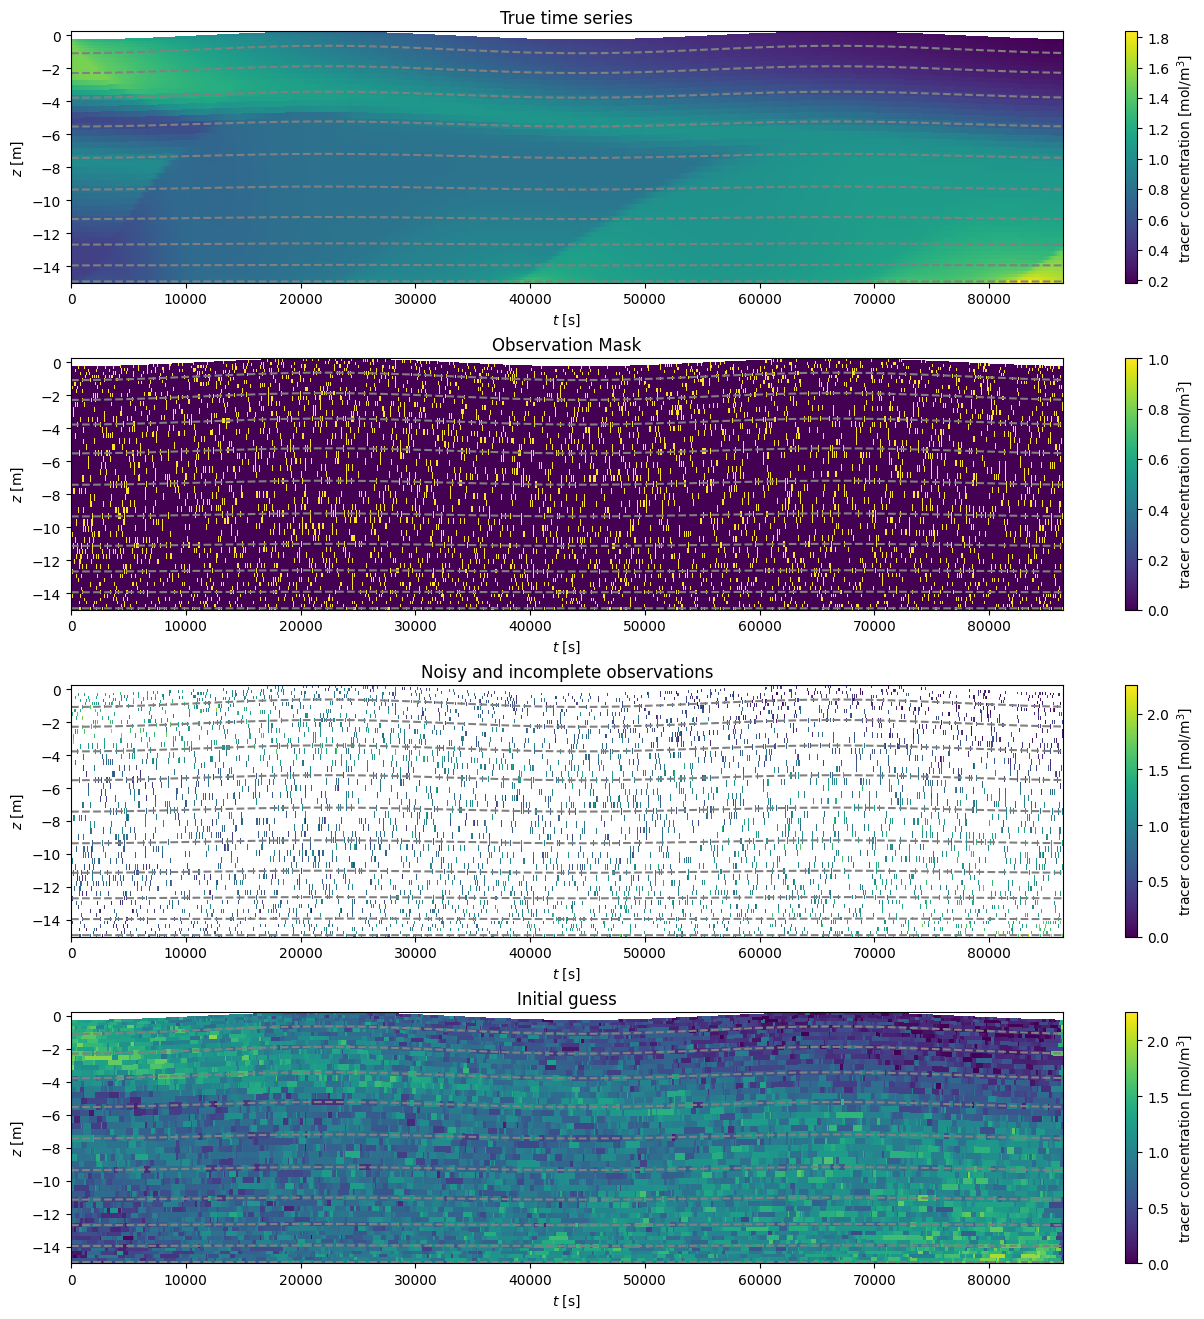

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(16,16))
fig.subplots_adjust(hspace=0.3)

show_tracer_ts(ts.fields['pelagic'].squeeze(), ax=ax[0], title="True time series")
show_tracer_ts(observations.mask.fields['pelagic'].squeeze(), ax=ax[1], title="Observation Mask")
show_tracer_ts(valid_obs, ax=ax[2], title="Noisy and incomplete observations")
show_tracer_ts(initialization.fields['pelagic'], ax=ax[3], title="Initial guess")

As our simulation of advection and diffusion needs the layer heights and diffusivities as additional inputs, we need to define a *dynamic_inputs* object so that we can follow the da-tools conventions.

In [ ]:
# we define the dynamic_inputs State object that is needed for the simulation
dynamic_inputs = State(TensorDict({'h': h_input, 'nu': nu_input}, batch_size=h_input.shape[:2]), time_axis=forecast_steps)

We now define a simple one-time-step function that matches the da-tools conventions.

In order to use the 4Dvar function, you should always have a function like this taking the *State* object, *dt*, *dynamic_inputs* and *static_inputs*.

In [ ]:
def next_step_function(x: State, dt: float, dynamic_inputs: State, static_inputs: State):
    "this time stepping function expects the input State x to have a single field called 'pelagic'"
    B, T = x.fields.batch_size[:2]
    x_tensor = x.fields.reshape(-1)["pelagic"]  # combine batch and time dimensions, leave others intact
    h_tensor = dynamic_inputs.fields.reshape(-1)['h']
    nu_tensor = dynamic_inputs.fields.reshape(-1)['nu']
    if h_tensor.shape[0] > x_tensor.shape[0]:
        h_tensor = h_tensor[1:]
    if nu_tensor.shape[0] > x_tensor.shape[0]:
        nu_tensor = nu_tensor[:-1]
    integrated = forward_operator(x_tensor, dt, h_tensor, nu_tensor)
    integrated = integrated.reshape(B, T, *integrated.shape[1:])  # re-add batch dimension
    new_fields = TensorDict({'pelagic': integrated}, batch_size=(B, T))
    return State(new_fields, time_axis=x.time_axis + dt)  # return State object, advancing time

# Perform data assimilation with 4DVar

Now, we want to perform the actual data assimilation.
First, we perform hard-constraint 4DVar, then weak-constraint 4DVar:

## Perform hard-constraint 4DVar

As hard-constraint 4DVar only optimizes the initial state and thus repeatedly performs a rollout over the entire time series, we restrict the observation window for 4DVar.
This significantly speeds up the optimization.
Note that the results should remain accurate.

In [ ]:
n_obs_steps = 200
time_window = (observations.state.time_axis[0], observations.state.time_axis[n_obs_steps])

obs_op_opt = obs_op.restrict_time_domain(*time_window)
observations_opt = observations.restrict_time_domain(*time_window)
dynamic_inputs_opt = dynamic_inputs.restrict_time_domain(*time_window)

We perform the data assimilation with hard-constraint 4DVar. This should take a few minutes to run.

In [ ]:
t0 = time()
assimilated_ic = hc4dvar_single_window(next_step_function, 
                                       observations_opt, 
                                       obs_op_opt,
                                       initialization_hc,
                                       dynamic_inputs_opt,                                        
                                       optimizer_pars={'lr': 0.5},
                                       n_steps=5,
                                       verbose=0)                                     
print(f'Total time for the 4Dvar optimization: {time() - t0} seconds')

Total time for the 4Dvar optimization: 224.6290681362152 seconds


As hard-constraint 4DVar only gives us an estimate of the initial state, we need to manually perform a rollout in order to get the assimilated time series:

In [ ]:
assimilated_trajectory_hc = forward_operator.integrate(assimilated_ic.fields['pelagic'][0].detach().cpu(), time_step, h_input, nu_input).squeeze()

## Perform weak-constraint 4DVar

For weak-constraint 4DVar, we need to specify the model error distribution. For simplicity, we choose a spherical or constant model error distribution.

In [ ]:
n_steps = true_ts.time_axis.nelement()
model_error_distribs = DiagonalGaussian(TensorDict({'pelagic': torch.zeros(1, n_steps - 1, 1, N)}), 
                                        TensorDict({'pelagic': torch.ones(1, n_steps - 1, 1, N)}))

We perform the data assimilation with weak-constraint 4DVar. Again, this should take a few minutes to compute.

In [ ]:
t0 = time()
assimilated_states = wc4dvar_single_window(next_step_function, 
                                          observations, 
                                          obs_op, 
                                          model_error_distribs,
                                          x_init=initialization,
                                          dynamic_inputs=dynamic_inputs,
                                          optimizer_pars={'lr': 1.},
                                          alpha=1e6,
                                          n_steps=100,
                                          verbose=0)                                       
print(f'Total time for the 4Dvar optimization: {time() - t0} seconds')

assimilated_states = assimilated_states.detach()

Total time for the 4Dvar optimization: 218.65318322181702 seconds


# Evaluation and comparison of assimilated trajectories

Now, we want to evaluate the accuracy of the assimilated states and compare hard- and weak-constraint 4DVar. First, we show the assimilated states and the corresponding errors:

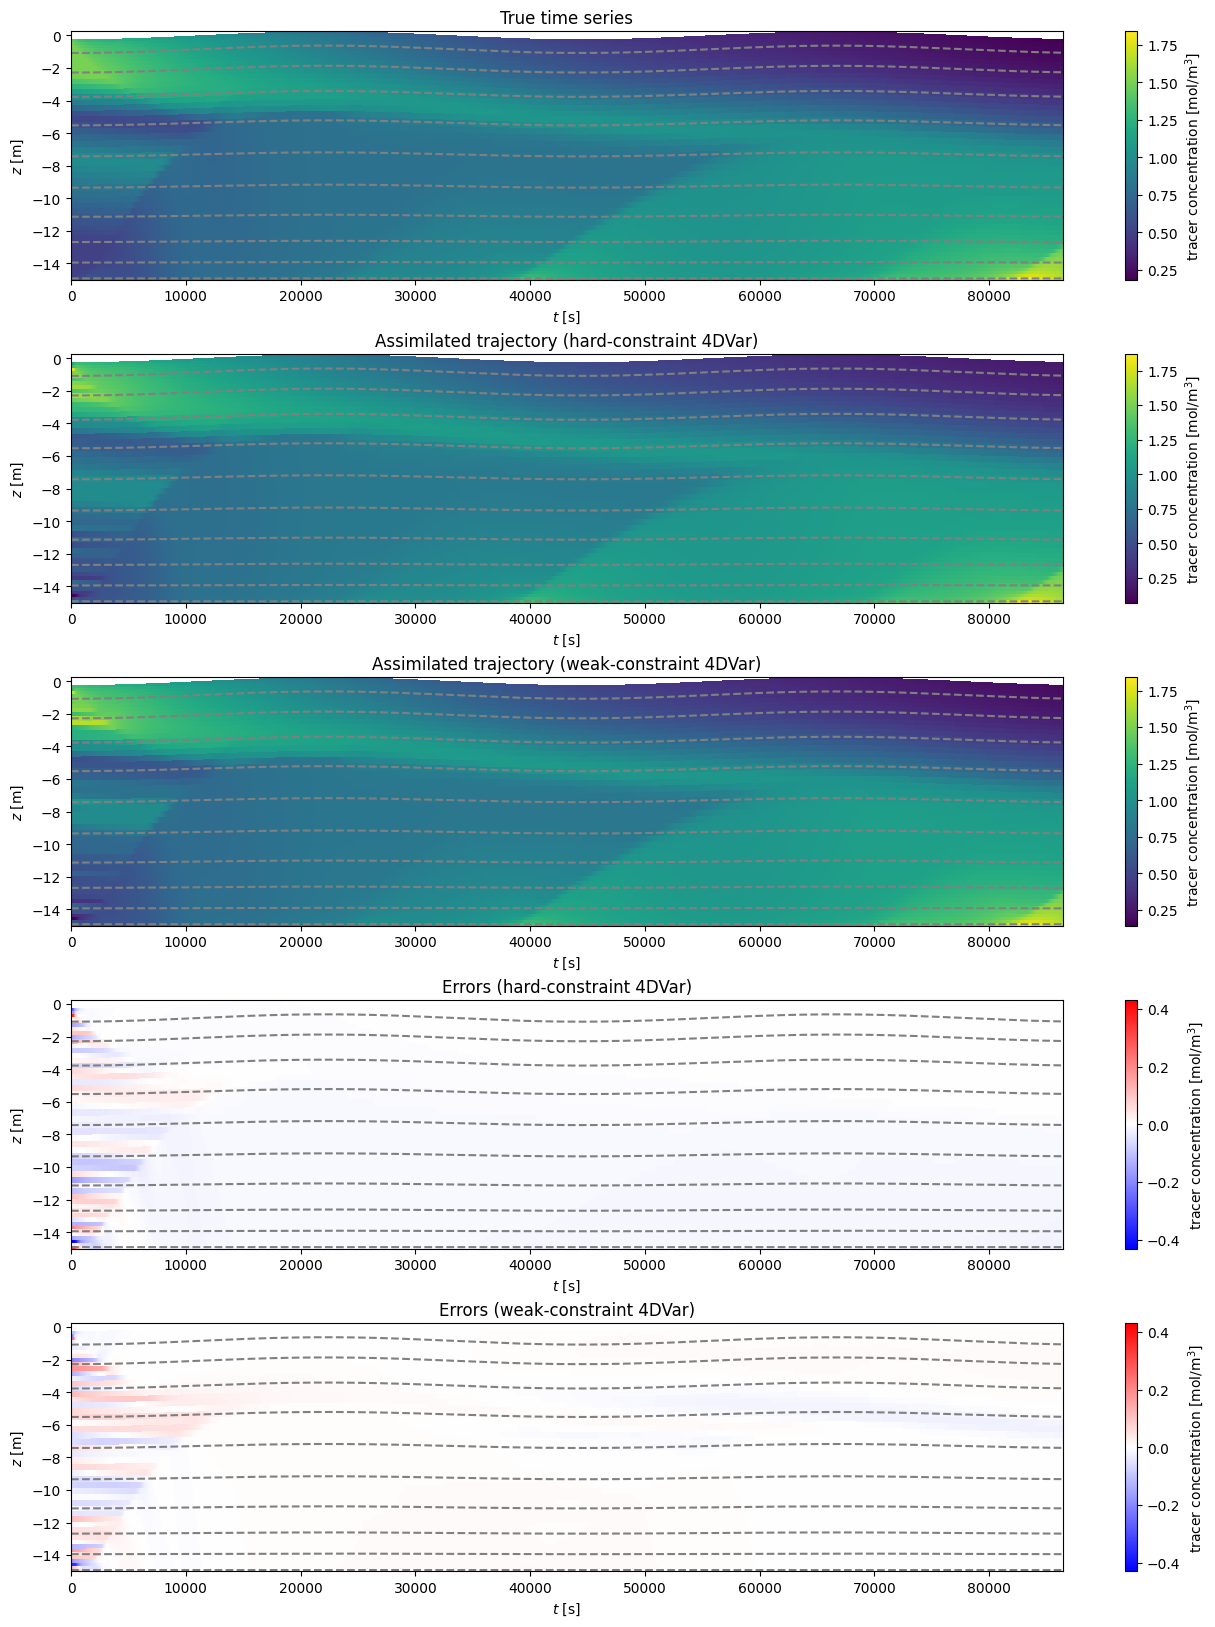

In [ ]:
errors_hc = (assimilated_trajectory_hc - true_ts.fields['pelagic'].squeeze())
errors_wc = (assimilated_states.fields['pelagic'] - true_ts.fields['pelagic'])[0]
vmax_abs = torch.maximum(torch.max(torch.abs(errors_hc)), torch.max(torch.abs(errors_wc)))

fig, ax = plt.subplots(5, 1, figsize=(16,20))
fig.subplots_adjust(hspace=0.3)
show_tracer_ts(ts.fields['pelagic'].squeeze(), ax=ax[0], title="True time series")
show_tracer_ts(assimilated_trajectory_hc, ax=ax[1], title="Assimilated trajectory (hard-constraint 4DVar)")
show_tracer_ts(assimilated_states.fields['pelagic'], ax=ax[2], title="Assimilated trajectory (weak-constraint 4DVar)")
show_tracer_ts(errors_hc, ax=ax[3], cmap="bwr", title="Errors (hard-constraint 4DVar)", vmin=-vmax_abs, vmax=vmax_abs)
show_tracer_ts(errors_wc, ax=ax[4], cmap="bwr", title="Errors (weak-constraint 4DVar)", vmin=-vmax_abs, vmax=vmax_abs)

Since hard-constraint 4DVar optimizes the initial state only, let us compare the true initial states with the assimilated ones:

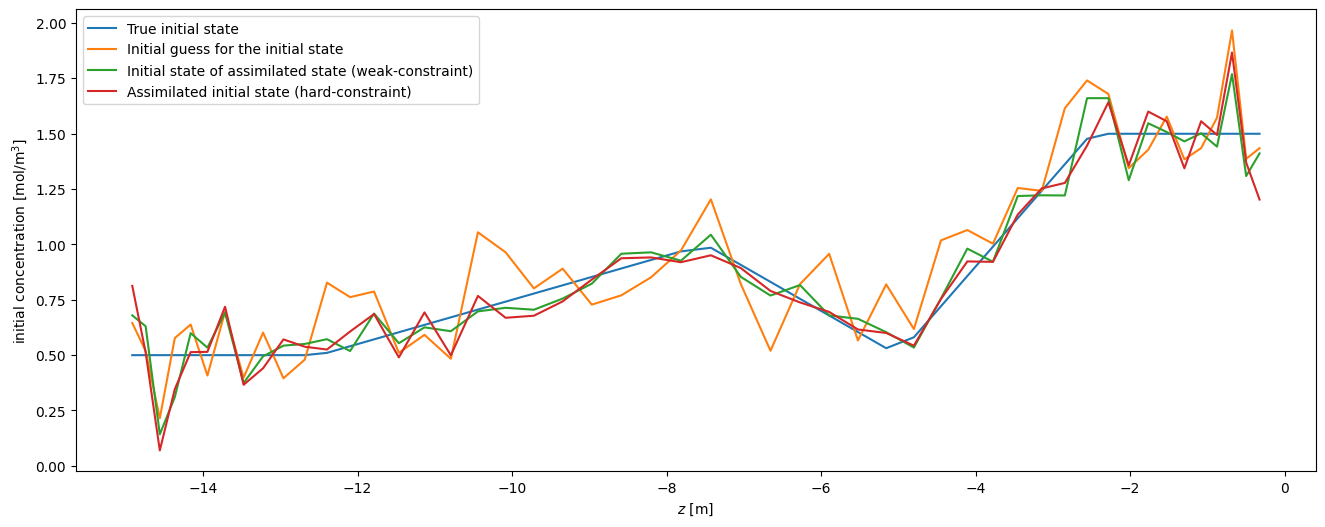

In [ ]:
assimilated_initial_state = assimilated_states.fields['pelagic'][0,0]

plt.figure(figsize=(16,6))
plt.plot(z[0], true_initial_state.fields['pelagic'].squeeze(), label='True initial state')
plt.plot(z[0], initialization.fields['pelagic'][0,0].squeeze(), label='Initial guess for the initial state')
plt.plot(z[0], assimilated_initial_state.squeeze().detach(), label='Initial state of assimilated state (weak-constraint)')
plt.plot(z[0], assimilated_ic.fields['pelagic'].squeeze().detach(), label='Assimilated initial state (hard-constraint)')
plt.xlabel('$z$ [m]')
plt.ylabel('initial concentration [mol/m$^3$]')
plt.legend(); plt.show()

One important measure for the accuracy of the data assimilation is the mean squared error (MSE):

In [ ]:
MSE0_hc = torch.mean((initialization_hc.fields['pelagic'].squeeze() - true_initial_state.fields['pelagic']) **2)
MSE_hc = torch.mean((assimilated_ic.fields['pelagic'].squeeze() - true_initial_state.fields['pelagic']) **2)

MSE0_wc = torch.mean((initialization.fields['pelagic'].squeeze() - true_ts.fields['pelagic']) **2)
MSE_wc = torch.mean((assimilated_states.fields['pelagic'].squeeze() - true_ts.fields['pelagic']) **2)

print(f'Initial guess MSE (initial state only): {MSE0_hc} (mol/m³)²')
print(f'Assimilated state MSE (HC, initial state only): {MSE_hc} (mol/m³)²')

print(f'Initial guess MSE (whole time series): {MSE0_wc} (mol/m³)²')
print(f'Assimilated state MSE (WC, whole time series): {MSE_wc} (mol/m³)²')


Initial guess MSE (initial state only): 0.031843230414489915 (mol/m³)²
Assimilated state MSE (HC, initial state only): 0.01650510232214809 (mol/m³)²
Initial guess MSE (whole time series): 0.15467032893669716 (mol/m³)²
Assimilated state MSE (WC, whole time series): 0.11365689432247786 (mol/m³)²


Finally, we consider the root mean squared error (RMSE) as a function of time for both hard- and weak-constraint 4DVar and compare it to the total RMSE.

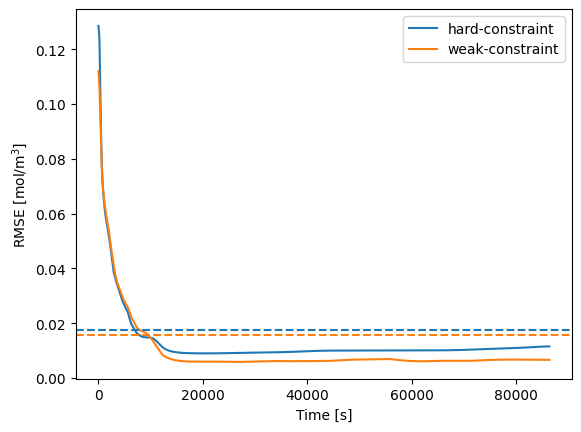

In [ ]:
RMSE_over_time_hc = torch.sqrt((errors_hc ** 2).squeeze().mean(dim=1))
RMSE_over_time_wc = torch.sqrt((errors_wc ** 2).squeeze().mean(dim=1))

RMSE_total_hc = torch.sqrt((errors_hc ** 2).squeeze().mean())
RMSE_total_wc = torch.sqrt((errors_wc ** 2).squeeze().mean())

fig, ax = plt.subplots()
plt.plot(true_ts.time_axis, RMSE_over_time_hc, label='hard-constraint')
plt.plot(true_ts.time_axis, RMSE_over_time_wc, label='weak-constraint')
plt.axhline(RMSE_total_hc, c='C0', ls='--')
plt.axhline(RMSE_total_wc, c='C1', ls='--')
ax.set_xlabel('Time [s]')
ax.set_ylabel('RMSE [mol/m$^3$]')
plt.legend(); plt.show()